In [8]:
import warnings;
warnings.filterwarnings('ignore');

In [9]:
from my_utils import loader, modeler
import pymc3 as pm
import arviz as az
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from theano import tensor as T
import matplotlib.pyplot as plt
import importlib
importlib.reload(loader)
importlib.reload(modeler)

<module 'my_utils.modeler' from '/workspaces/Thesis/Gaze_4_behavioural_biometrics/my_utils/modeler.py'>

[analisi](https://goldinlocks.github.io/Bayesian-logistic-regression-with-pymc3/)

## __Free viewing__

### __General empathy__

<AxesSubplot: >

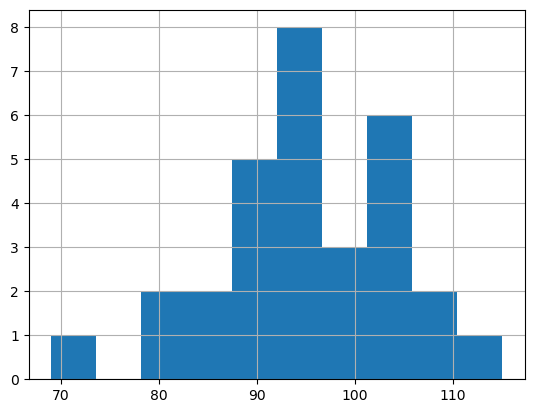

In [10]:
free_viewing_empathy = loader.load_eyeT_empathy_levels(experiment="free")
free_viewing_empathy.hist()

#### __Fixations__

In [11]:
free_fix_features_train, free_fix_labels_train, free_sac_features_train, free_sac_labels_train =  loader.get_eyeT_features_and_labels("train", "free")

In [12]:
free_fix_empathy, free_fix_empathy_trace = modeler.generate_neg_binomial_regression_model("free_fix_neg_bin_regression", free_fix_features_train, free_fix_labels_train)

##### Sampling diagnostics

In [14]:
az.summary(free_fix_empathy_trace, round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,4.54,0.02,4.50,4.57,0.00,0.00,2249.78,2486.90,1.0
b[0],0.10,0.14,-0.17,0.38,0.00,0.00,2617.94,2807.93,1.0
b[1],-0.02,0.03,-0.08,0.03,0.00,0.00,2274.26,2365.67,1.0
b[2],0.13,0.13,-0.13,0.38,0.00,0.00,2262.63,2586.92,1.0
b[3],-0.03,0.11,-0.23,0.17,0.00,0.00,2723.20,2096.09,1.0
b[4],-0.01,0.02,-0.06,0.03,0.00,0.00,3233.04,3164.09,1.0
b[5],-0.08,0.09,-0.26,0.08,0.00,0.00,2246.57,2533.48,1.0
b[6],0.03,0.04,-0.05,0.11,0.00,0.00,1692.88,2257.07,1.0
b[7],0.00,0.01,-0.01,0.01,0.00,0.00,4356.36,2988.61,1.0
b[8],-0.06,0.03,-0.13,-0.00,0.00,0.00,1541.42,2016.72,1.0


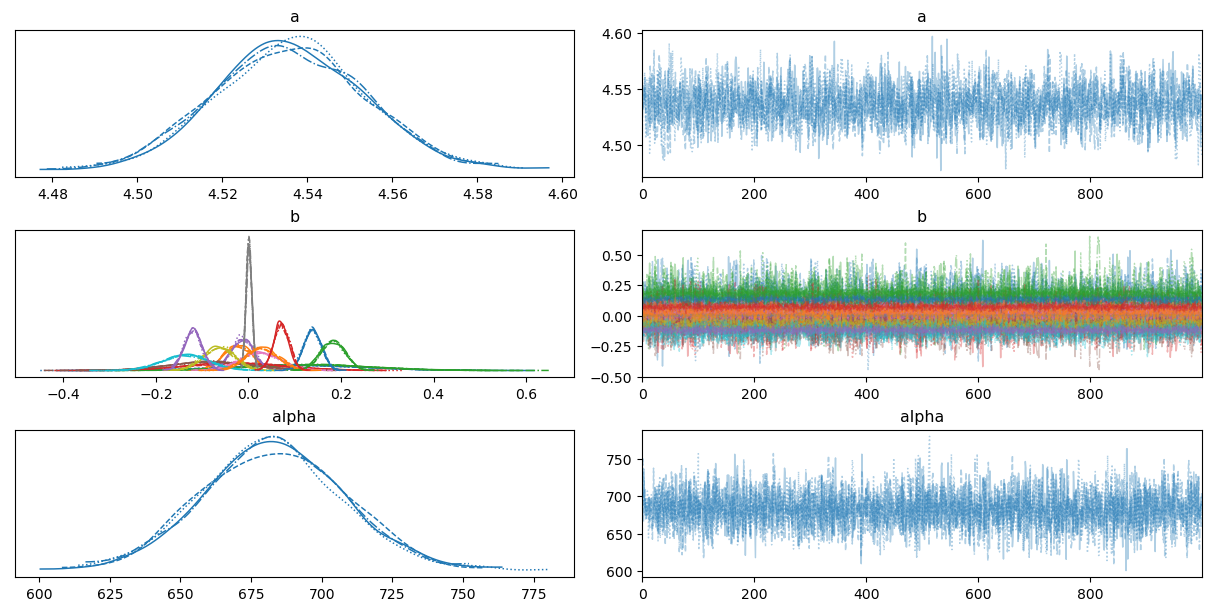

In [ ]:
az.plot_trace(free_fix_empathy_trace);

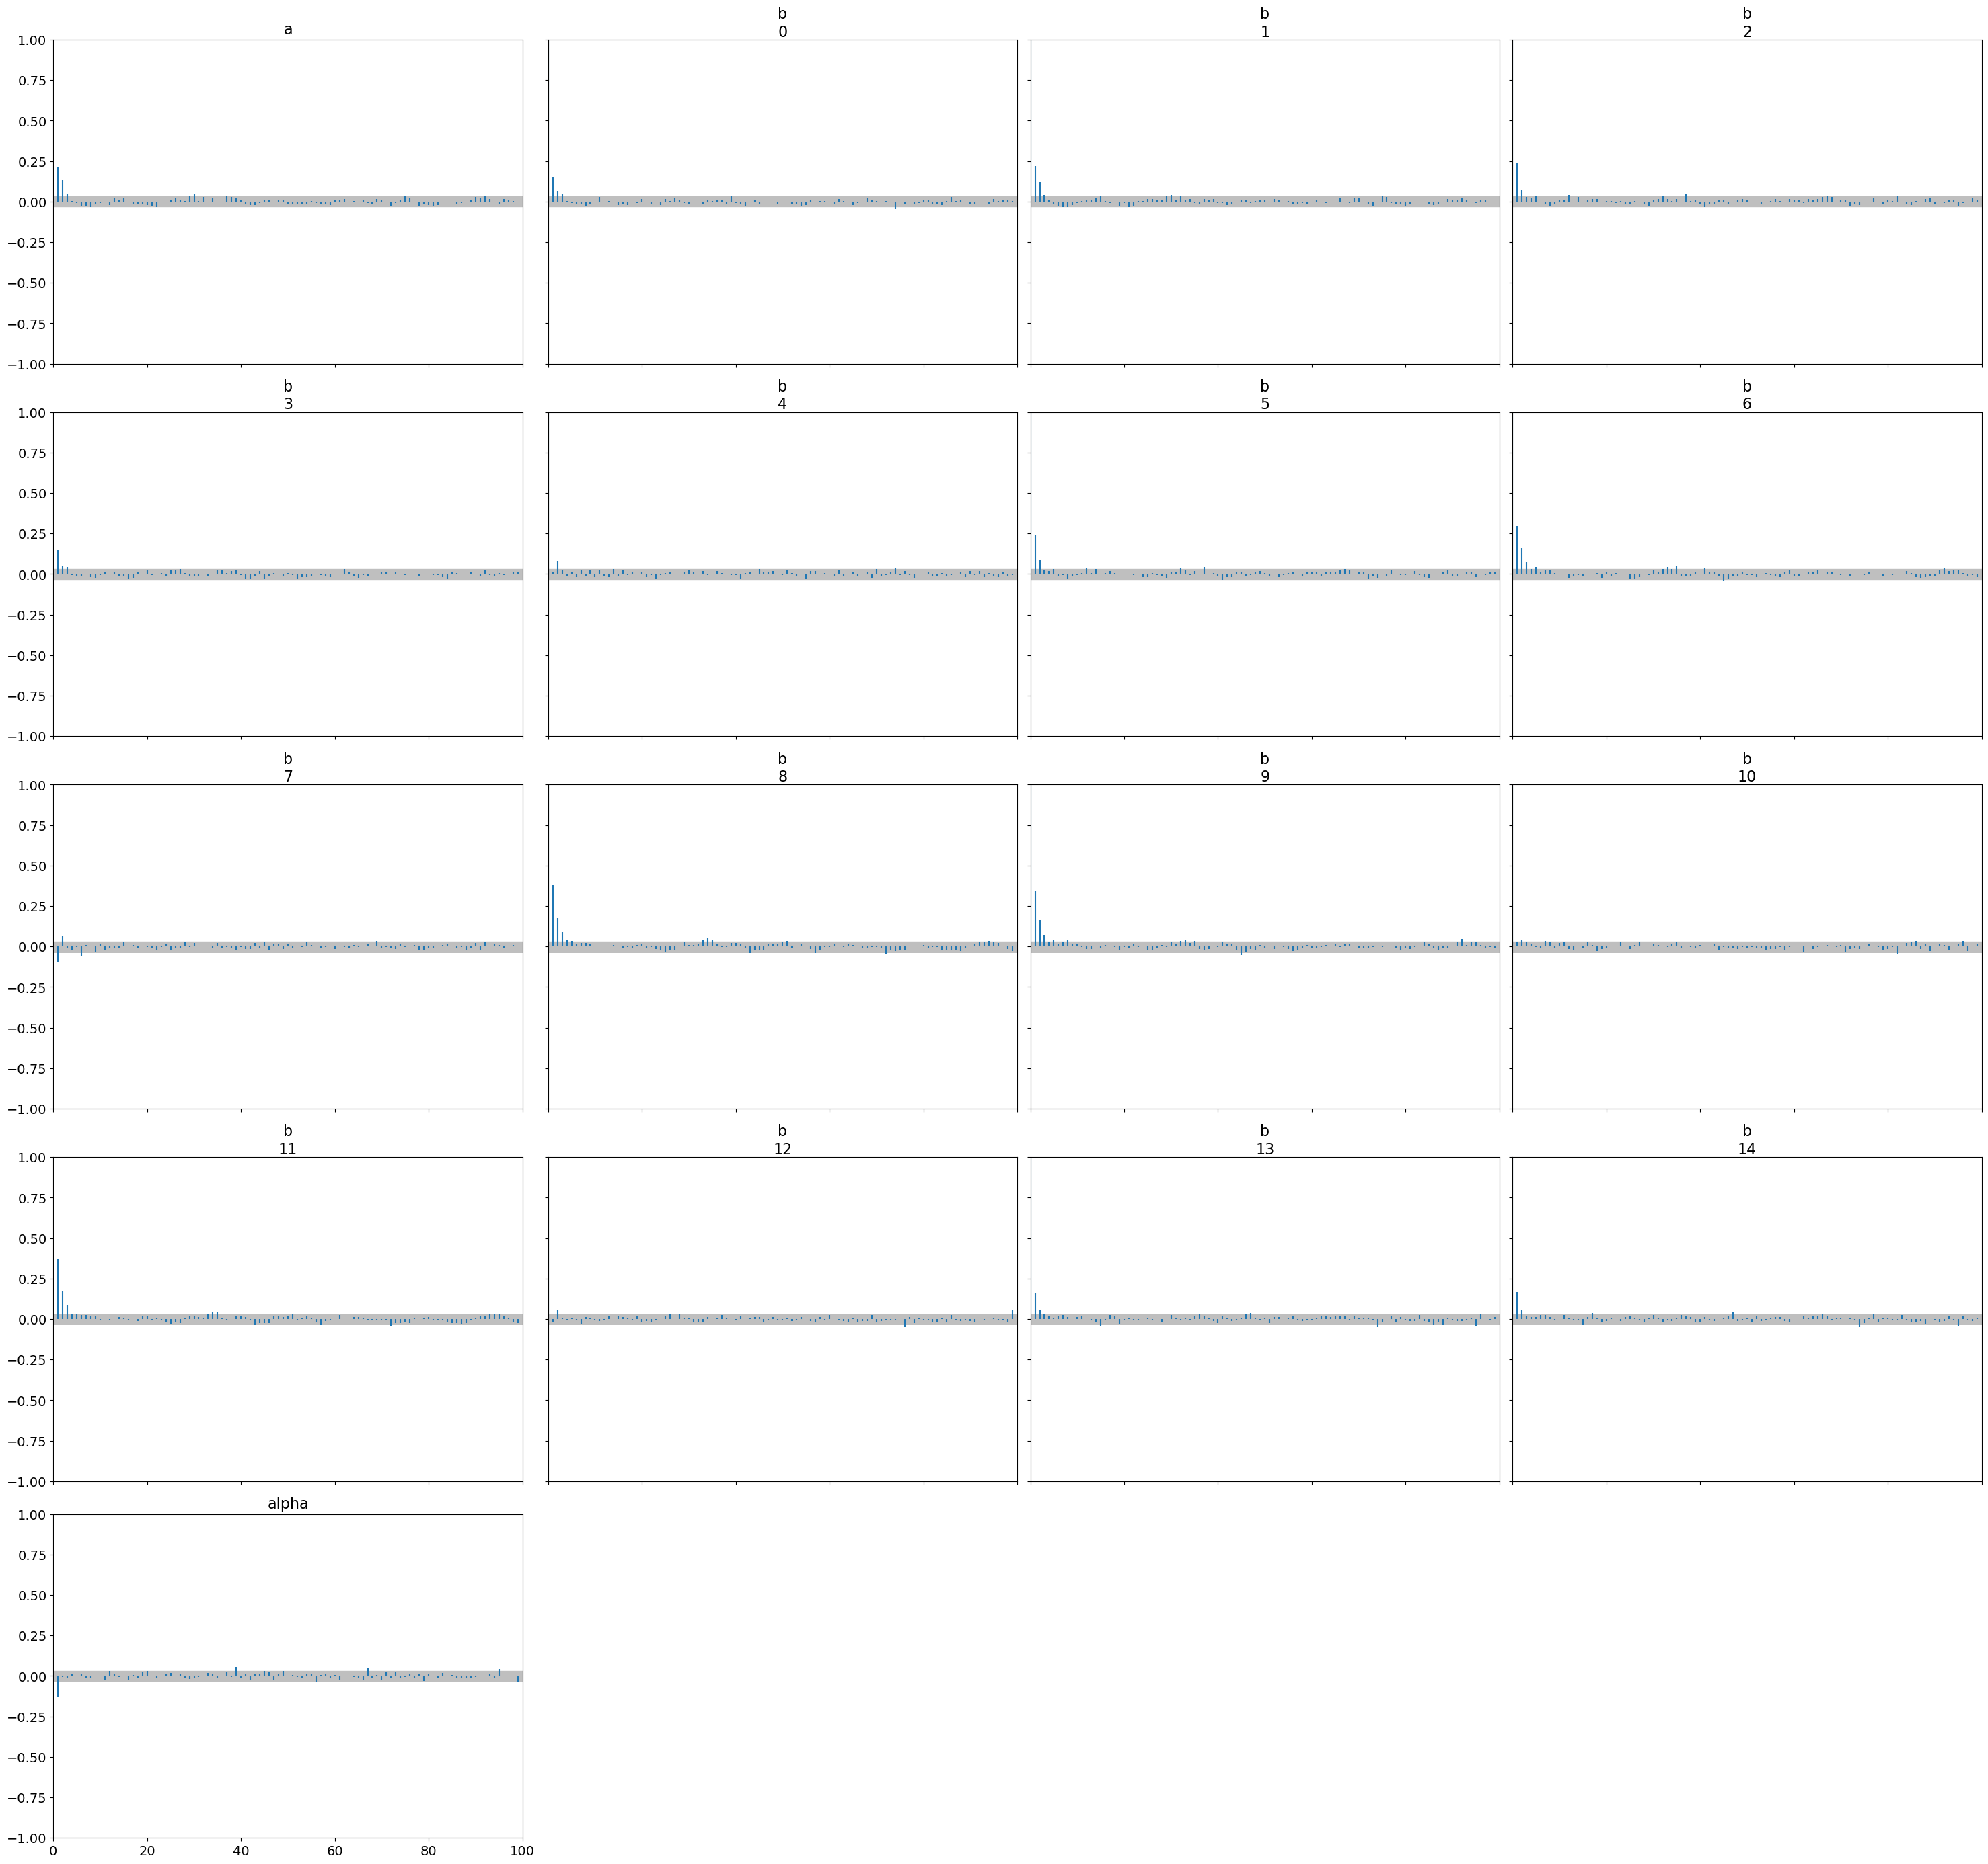

In [ ]:
az.plot_autocorr(free_fix_empathy_trace, combined=True);

##### Posterior predictive check

In [ ]:
free_fix_ppc = modeler.generate_model_ppc(free_fix_empathy, free_fix_empathy_trace)

In [ ]:
sampled_labels = free_fix_ppc["posterior_predictive"]["empathy"][0].mean(axis=0)

In [ ]:
rmse, mape = modeler.get_regression_evaluation(free_fix_labels_train, sampled_labels)
print(f"RMSE:{rmse}")
print(f"MAPE:{mape}%")

RMSE:8.0
MAPE:6.67%


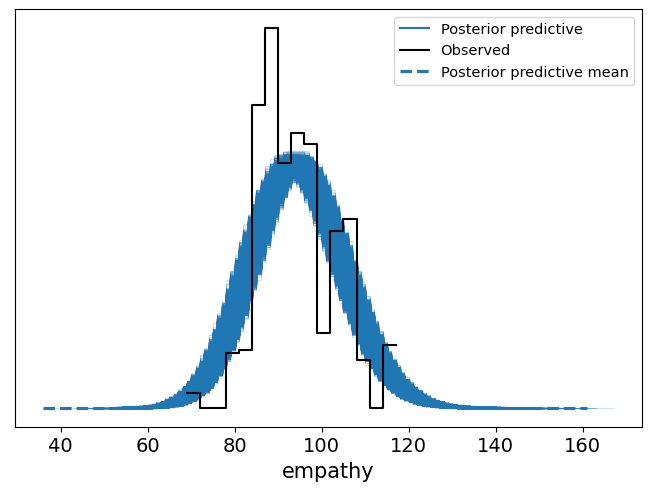

In [ ]:
az.plot_ppc(free_fix_ppc);

##### Test predictions

In [ ]:
free_fix_features_test, free_fix_labels_test, free_sac_features_test, free_sac_labels_test =  loader.get_eyeT_features_and_labels(dset="test", experiment="free")
free_fix_predictions = modeler.generate_model_predictions(free_fix_empathy, free_fix_features_test, free_fix_empathy_trace)

In [ ]:
rmse, mape = modeler.get_regression_evaluation(free_fix_predictions, free_fix_labels_test)
print(f"RMSE:{rmse}")
print(f"MAPE:{mape}%")

RMSE:8.23
MAPE:6.78%


#### __Saccades__

In [ ]:
free_sac_empathy, free_sac_empathy_trace = modeler.generate_neg_binomial_regression_model("free_sac_neg_bin_regression", free_sac_features_train, free_sac_labels_train)

Sampling 4 chains for 3_000 tune and 1_000 draw iterations (12_000 + 4_000 draws total) took 621 seconds.


Saving model...


##### Sampling diagnostics

In [ ]:
az.summary(free_sac_empathy_trace, round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,4.56,0.02,4.53,4.59,0.00,0.00,2003.11,2152.97,1.0
b[0],0.02,0.04,-0.05,0.08,0.00,0.00,2331.80,2606.92,1.0
b[1],-0.02,0.02,-0.06,0.01,0.00,0.00,2157.88,2484.45,1.0
b[2],-0.09,0.07,-0.24,0.05,0.00,0.00,2510.99,2380.07,1.0
b[3],-0.05,0.06,-0.16,0.05,0.00,0.00,2357.13,2665.56,1.0
b[4],-0.02,0.05,-0.13,0.07,0.00,0.00,2655.22,2358.36,1.0
b[5],0.11,0.06,0.00,0.21,0.00,0.00,2783.66,2847.52,1.0
b[6],-0.00,0.03,-0.06,0.04,0.00,0.00,2329.77,2508.77,1.0
b[7],-0.00,0.00,-0.01,0.01,0.00,0.00,4886.35,3242.04,1.0
b[8],0.01,0.02,-0.03,0.05,0.00,0.00,2510.06,2812.20,1.0


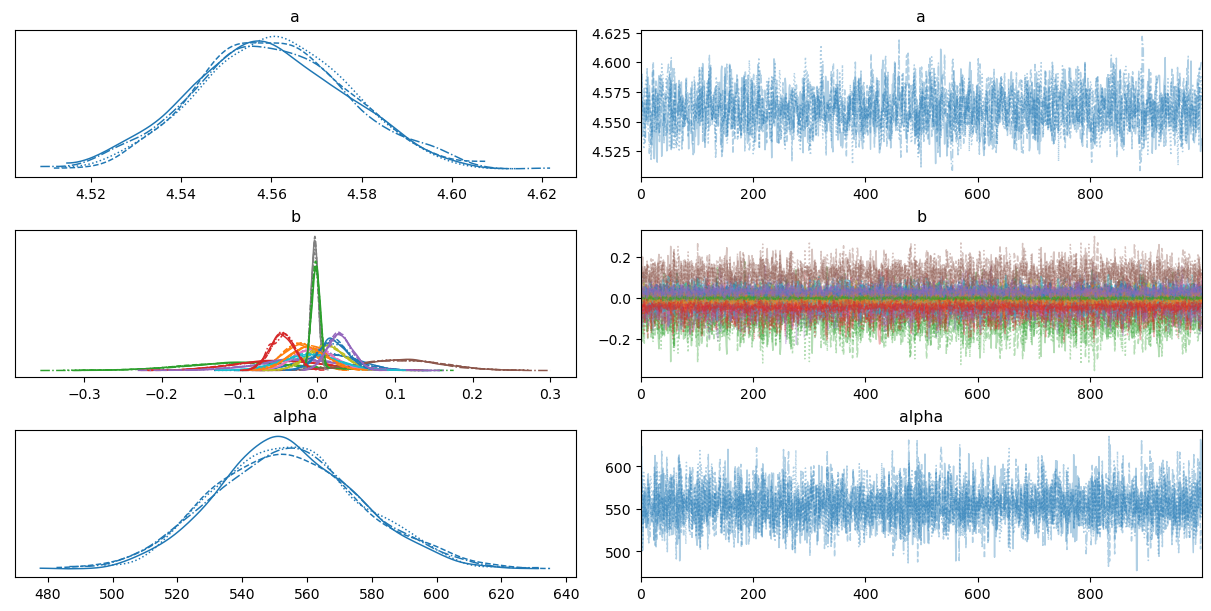

In [ ]:
trace = az.plot_trace(free_sac_empathy_trace);

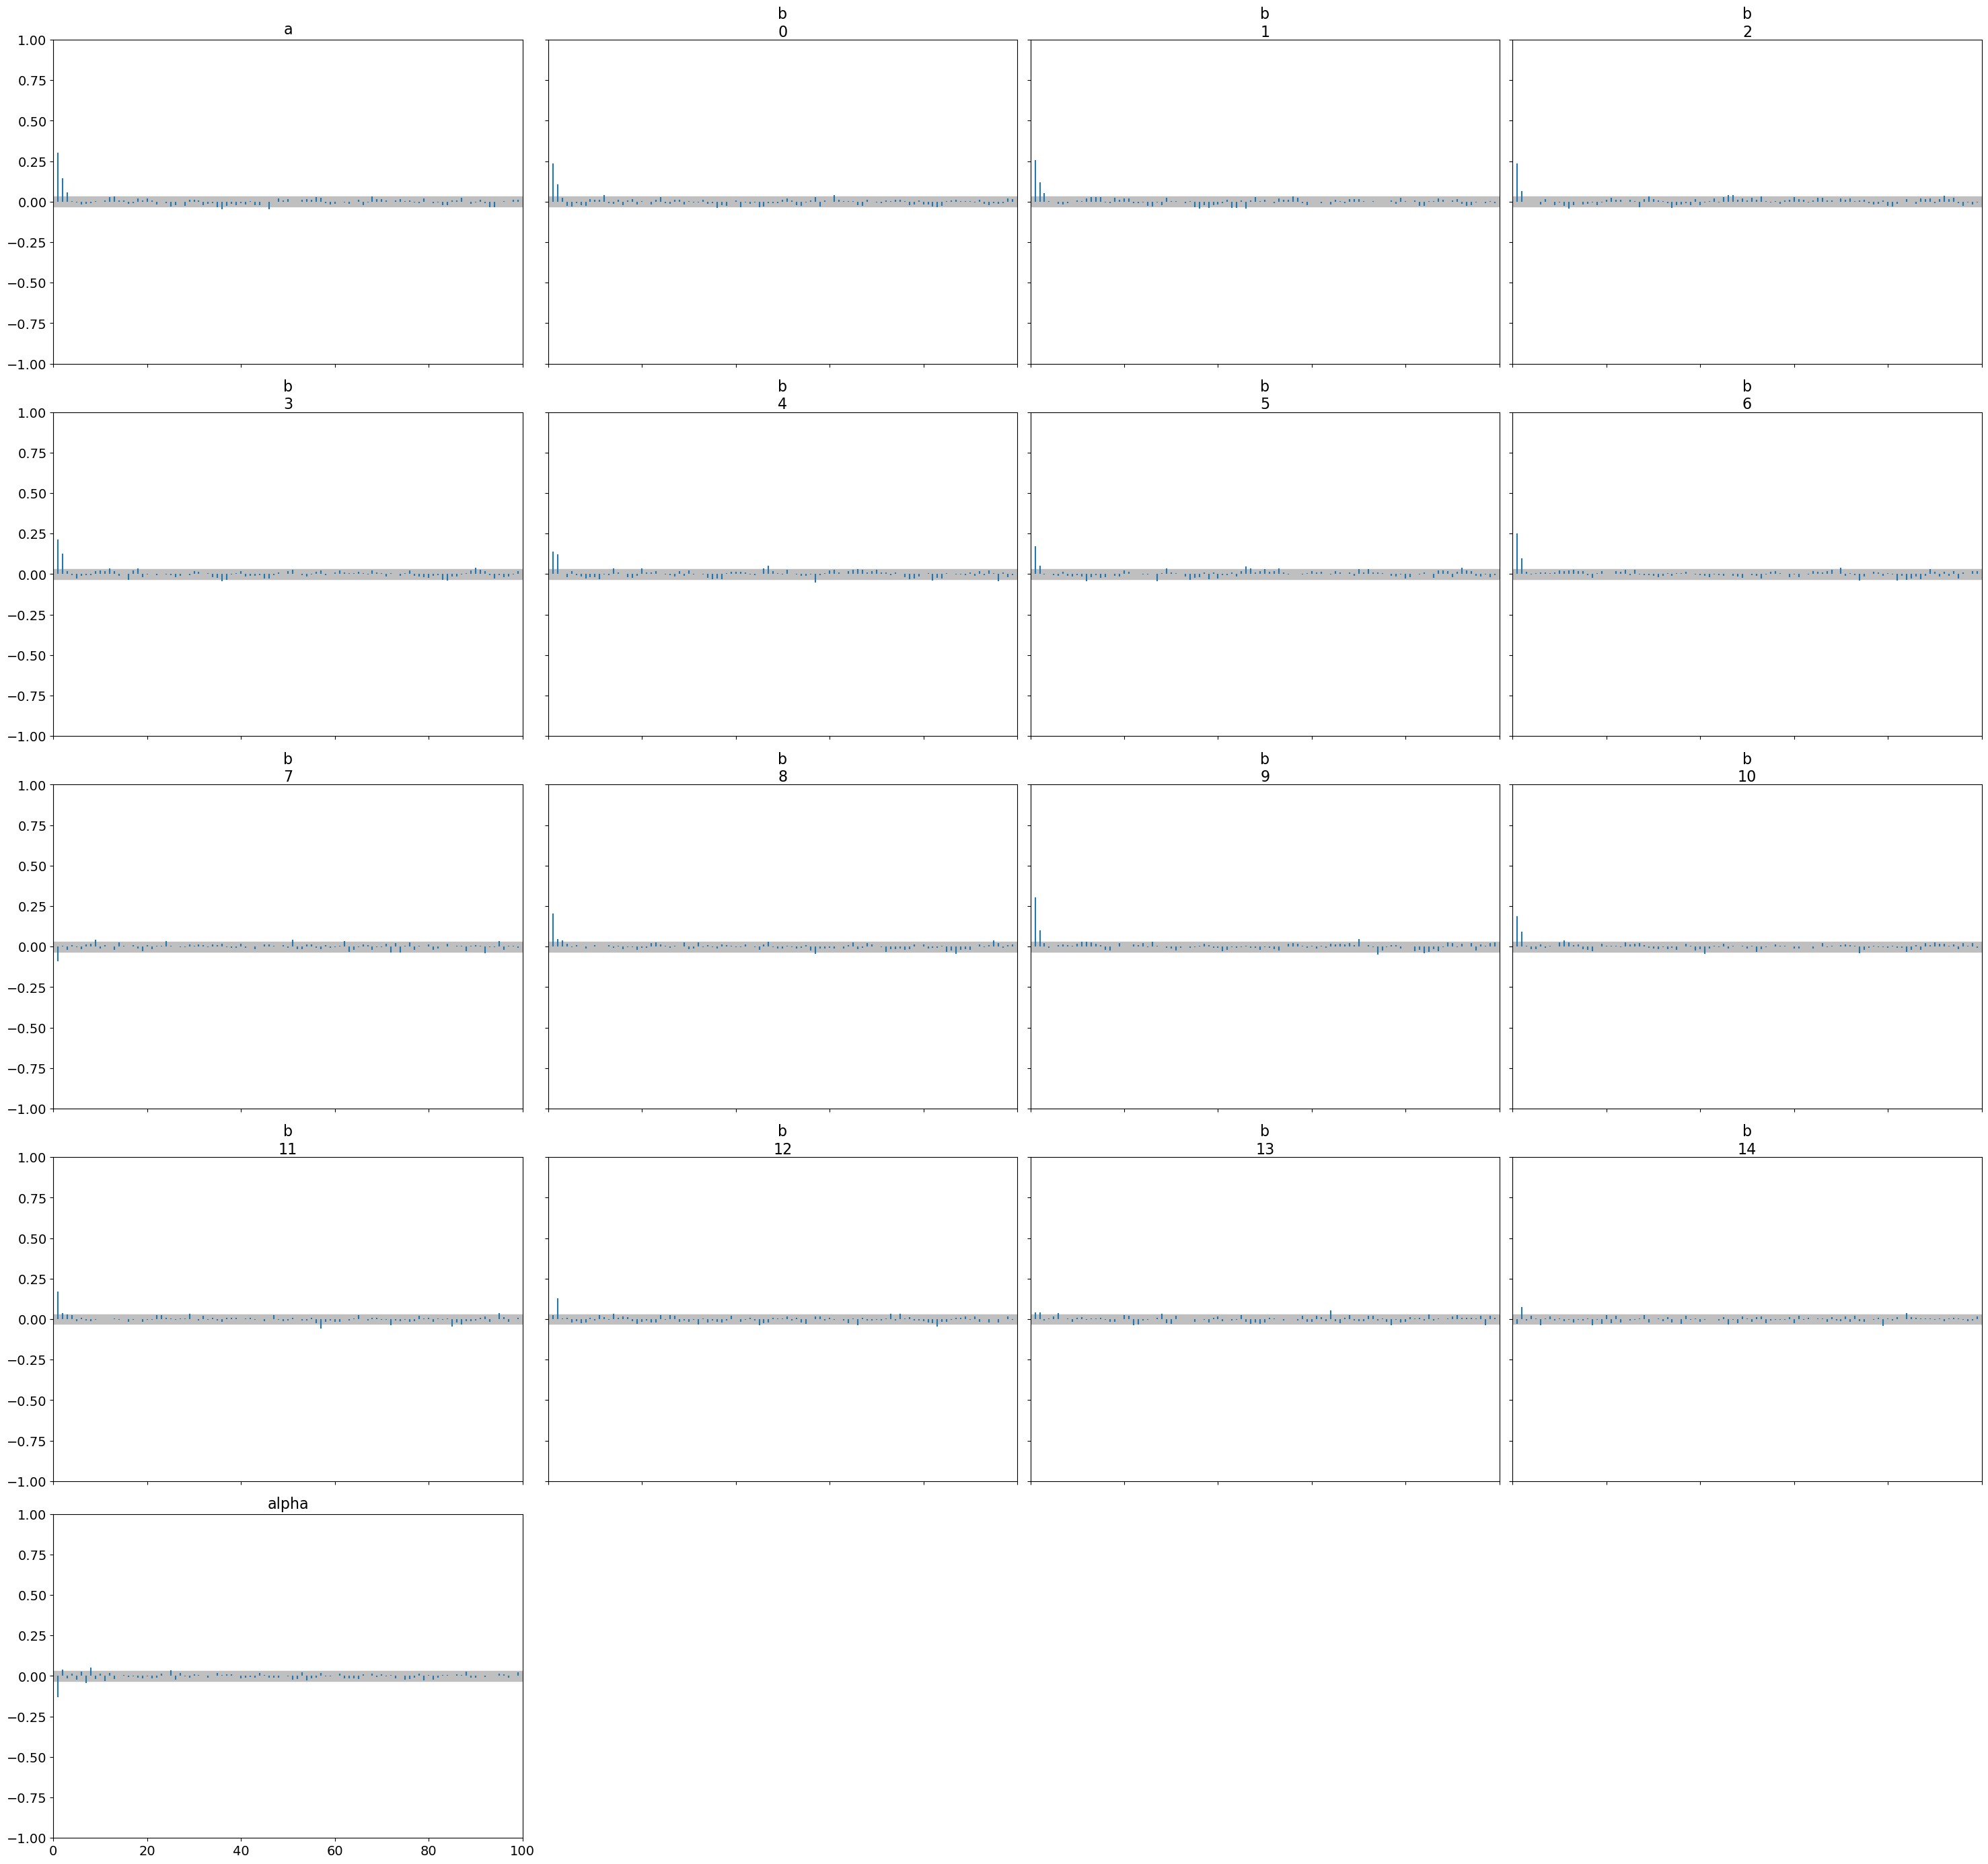

In [ ]:
az.plot_autocorr(free_sac_empathy_trace, combined=True);

##### Posterior predictive check

In [ ]:
free_sac_ppc = modeler.generate_model_ppc(free_sac_empathy, free_sac_empathy_trace)
sampled_labels = free_sac_ppc["posterior_predictive"]["empathy"][0].mean(axis=0)
rmse, mape = modeler.get_regression_evaluation(free_sac_labels_train, sampled_labels)
print(f"RMSE:{rmse}")
print(f"MAPE:{mape}%")

RMSE:8.21
MAPE:6.94%


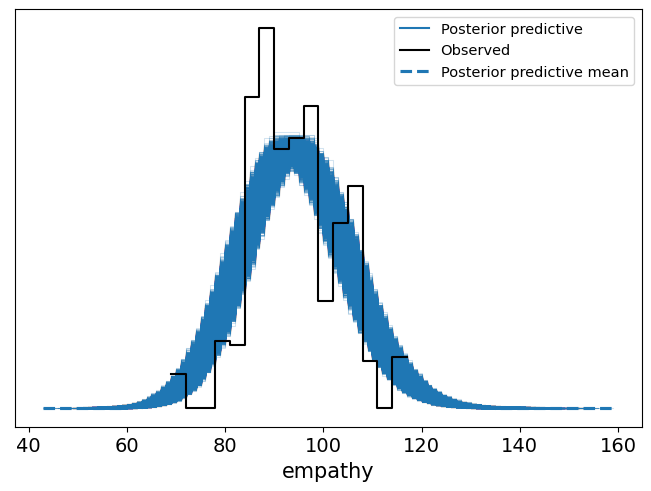

In [ ]:
az.plot_ppc(free_sac_ppc);

##### Predictions

In [ ]:
free_sac_predictions = modeler.generate_model_predictions(free_sac_empathy, free_sac_features_test, free_sac_empathy_trace)
rmse, mape = modeler.get_regression_evaluation(free_sac_predictions, free_sac_labels_test)
print(f"RMSE:{rmse}")
print(f"MAPE:{mape}%")

RMSE:8.31
MAPE:6.97%


#### __Combined predictions__

In [ ]:
free_fix_stimuli, free_sac_stimuli = loader.get_stimuli("test", "free")
predicted_empathy = modeler.combine_predictions(free_fix_predictions, free_fix_stimuli, free_sac_predictions, free_sac_stimuli)
real_empathy_aff_values = [free_viewing_empathy[k[1]] for k in predicted_empathy.keys()]
rmse, mape = modeler.get_regression_evaluation(real_empathy_aff_values, [level for level in predicted_empathy.values()])
print(f"RMSE:{rmse}")
print(f"MAPE:{mape}%")

RMSE:9.02
MAPE:7.66%


## __Task oriented__

### __General empathy__

#### __Fixations__

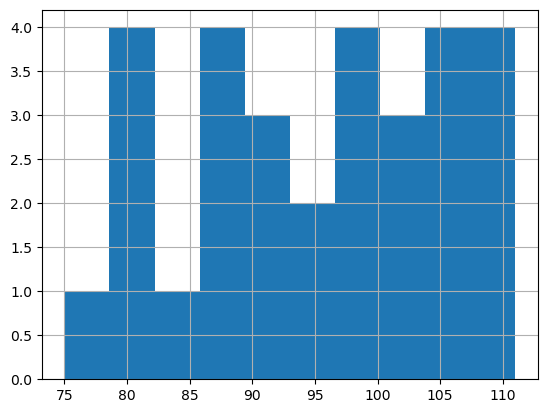

In [ ]:
task_oriented_empathy = loader.load_eyeT_empathy_levels(experiment="task")
task_oriented_empathy.hist();

In [ ]:
task_fix_features_train, task_fix_labels_train, task_sac_features_train, task_sac_labels_train =  loader.get_eyeT_features_and_labels("train", "task")

In [ ]:
task_fix_empathy, task_fix_empathy_trace = modeler.generate_neg_binomial_regression_model("task_fix_neg_bin_regression", task_fix_features_train, task_fix_labels_train)

Sampling 2 chains for 3_000 tune and 1_000 draw iterations (6_000 + 2_000 draws total) took 8683 seconds.


Saving model...


##### Sampling diagnostics

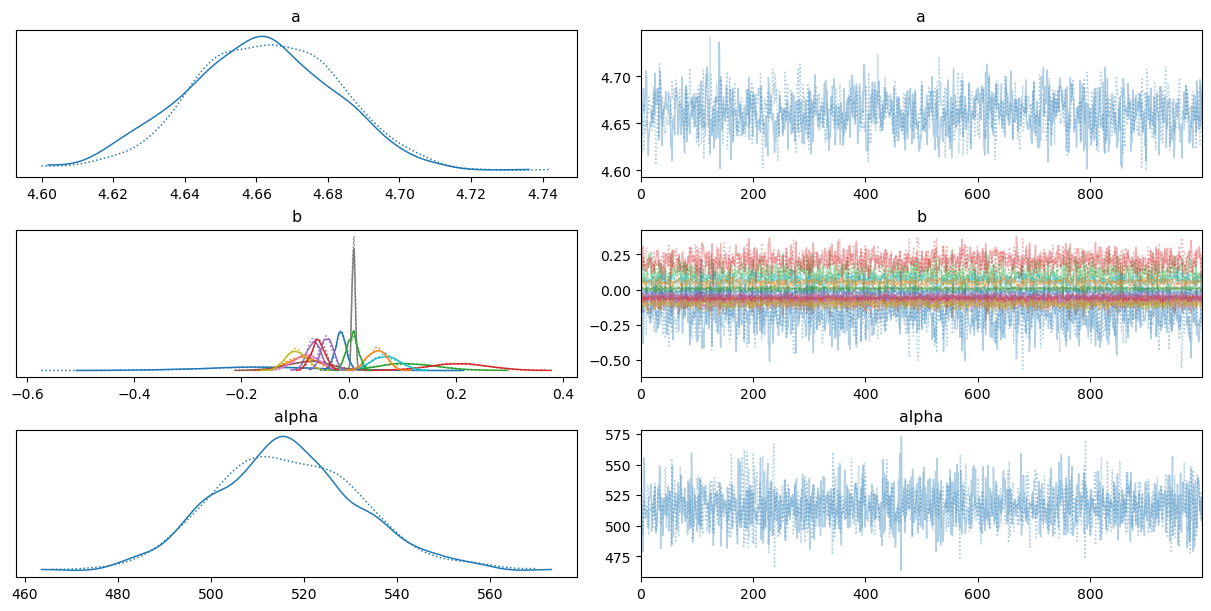

In [18]:
az.plot_trace(task_fix_empathy_trace);

In [16]:
az.summary(task_fix_empathy_trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,4.662,0.021,4.623,4.700,0.001,0.000,1218.0,1401.0,1.00
b[0],-0.161,0.115,-0.381,0.051,0.003,0.002,1311.0,1274.0,1.00
b[1],-0.086,0.027,-0.141,-0.039,0.001,0.001,1154.0,1333.0,1.00
b[2],0.111,0.055,0.004,0.212,0.002,0.001,1287.0,1364.0,1.00
b[3],0.204,0.056,0.098,0.310,0.002,0.001,1321.0,1538.0,1.00
b[4],-0.065,0.013,-0.088,-0.041,0.000,0.000,2166.0,1507.0,1.00
b[5],-0.074,0.041,-0.153,0.003,0.001,0.001,1286.0,1341.0,1.00
b[6],-0.078,0.023,-0.121,-0.034,0.001,0.000,1234.0,1474.0,1.00
b[7],0.009,0.003,0.004,0.015,0.000,0.000,2109.0,1536.0,1.00
b[8],-0.098,0.018,-0.133,-0.067,0.001,0.000,1203.0,1163.0,1.01


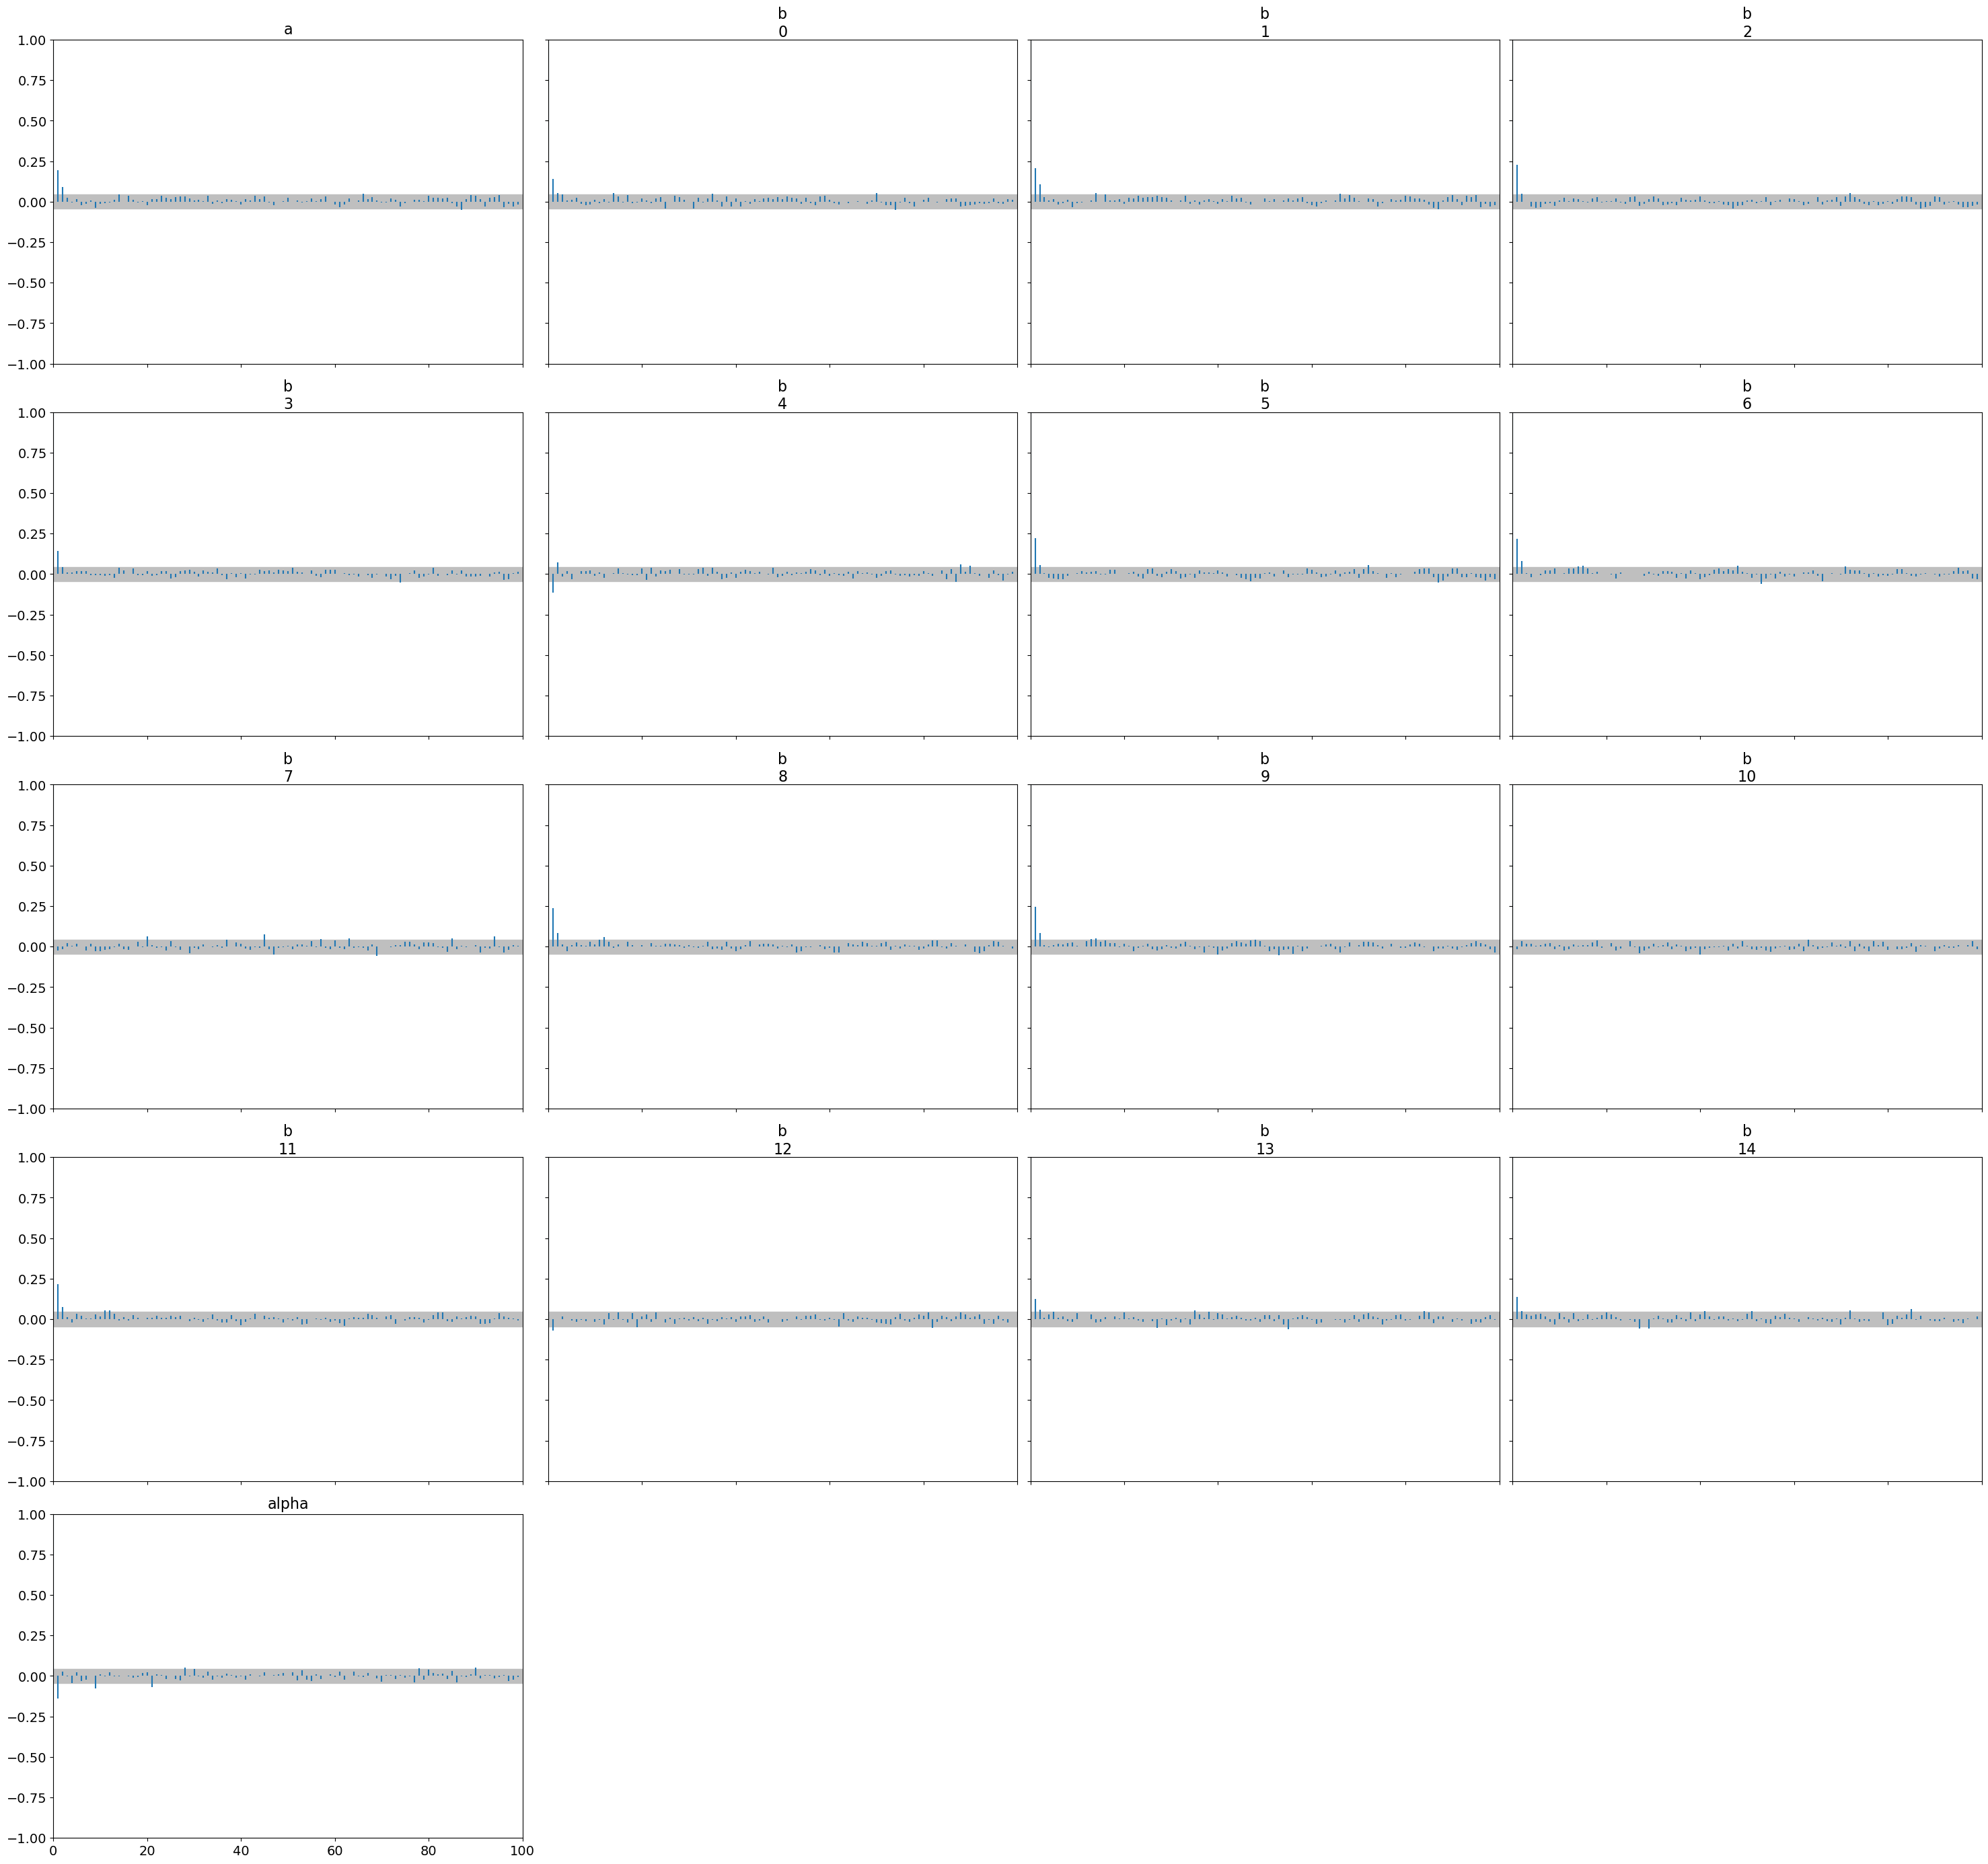

In [20]:
az.plot_autocorr(task_fix_empathy_trace, combined=True);

##### Posterior predictive check

In [22]:
task_fix_ppc = modeler.generate_model_ppc(task_fix_empathy, task_fix_empathy_trace)

In [23]:
sampled_labels = task_fix_ppc["posterior_predictive"]["empathy"][0].mean(axis=0)
rmse, mape = modeler.get_regression_evaluation(task_fix_labels_train, sampled_labels)
print(f"RMSE:{rmse}")
print(f"MAPE:{mape}%")

RMSE:10.26
MAPE:10.1%


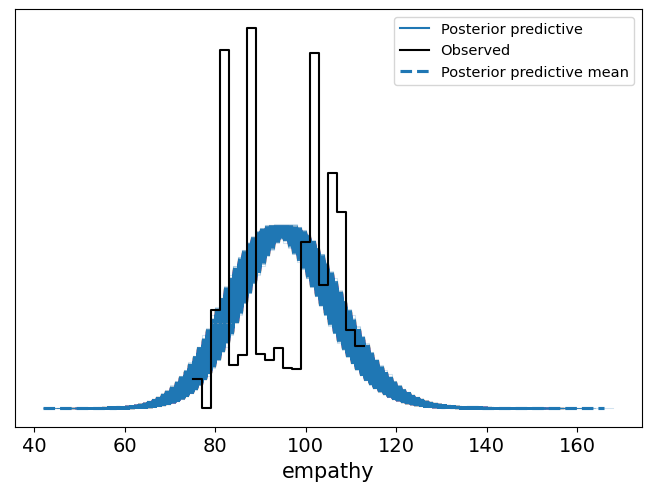

In [24]:
az.plot_ppc(task_fix_ppc);

##### Test predictions

In [26]:
task_fix_features_test, task_fix_labels_test, task_sac_features_test, task_sac_labels_test =  loader.get_eyeT_features_and_labels(dset="test", experiment="task")
task_fix_predictions = modeler.generate_model_predictions(task_fix_empathy, task_fix_features_test, task_fix_empathy_trace)
rmse, mape = modeler.get_regression_evaluation(task_fix_predictions, task_fix_labels_test)
print(f"RMSE:{rmse}")
print(f"MAPE:{mape}%")

RMSE:10.65
MAPE:9.83%


#### __Saccades__

In [27]:
task_sac_empathy, task_sac_empathy_trace = modeler.generate_neg_binomial_regression_model("task_sac_neg_bin_regression", task_sac_features_train, task_sac_labels_train)

Sampling 2 chains for 3_000 tune and 1_000 draw iterations (6_000 + 2_000 draws total) took 3897 seconds.


Saving model...
